## Analyse av MOWI per 22/09/2025

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import statsmodels.api as sm

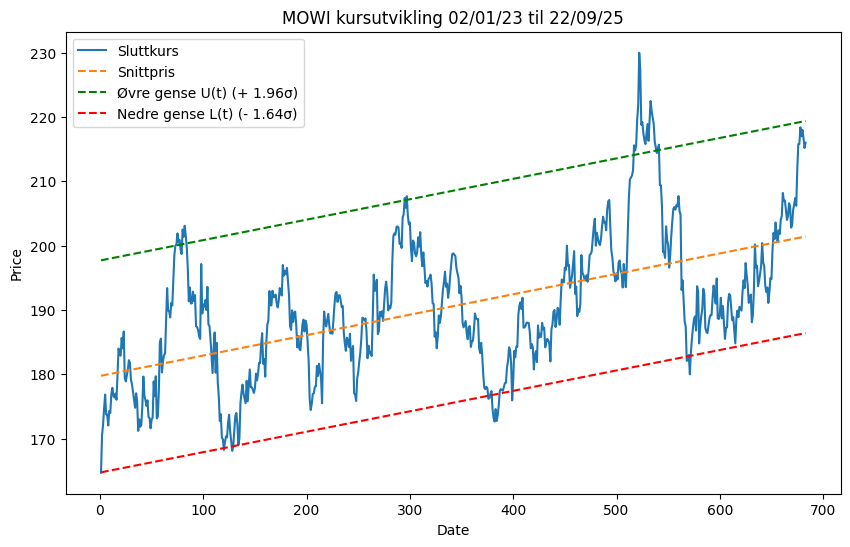

(197.72481871309387, 164.75805566515223, 0.043390960439754656, 216.0)

In [240]:
# Download data
df = pd.read_csv('Mowi Stock Price History.csv')
S = np.array(df['Price'].astype(float)[::-1])
t = range(1, len(S) + 1)
X_T = sm.add_constant(t)


# Run regression
model = sm.OLS(S, X_T).fit()
S_avg = model.predict(X_T)
u_t = np.std(model.resid, ddof=1)

S_u =  model.predict(X_T) + 1.96*u_t
S_l =  model.predict(X_T) - 1.64*u_t

slope = model.params[1]  # coefficient of t
mu = (1+ slope / np.mean(S))**255 - 1
# mu = np.log(S[-1] / S[-100]) * 255/100

# Plot
plt.figure(figsize=(10,6))
plt.plot(t, S , label='Sluttkurs')
plt.plot(t, S_avg, label='Snittpris', linestyle='--')
plt.plot(t, S_u, label='Øvre gense U(t) (+ 1.96σ)', linestyle='--', color='green')
plt.plot(t, S_l, label='Nedre gense L(t) (- 1.64σ)', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title("MOWI kursutvikling 02/01/23 til 22/09/25")
plt.show()
(S_u[0], S_l[0], mu, S[-1])

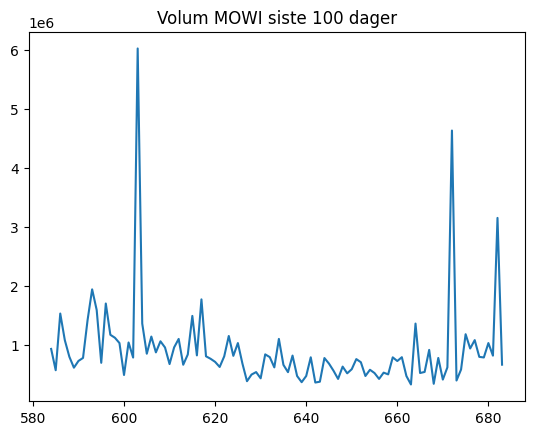

In [201]:
def parse_num(x):
    if isinstance(x, str):
        x = x.strip().upper()
        if x.endswith("M"):
            return float(x[:-1]) * 10**6
        elif x.endswith("K"):
            return float(x[:-1]) * 10**3
        else:
            return float(x)
    return float(x)

# Apply parser, reverse order, convert to numpy float array
vol = df['Vol.'][::-1].apply(parse_num).to_numpy(dtype=float)

plt.plot(t[-100:], vol[-100:])
plt.title("Volum MOWI siste 100 dager")
plt.show()

Reflected Lognormal parameters: 0.08535634184148594 0 0.15993545873751308


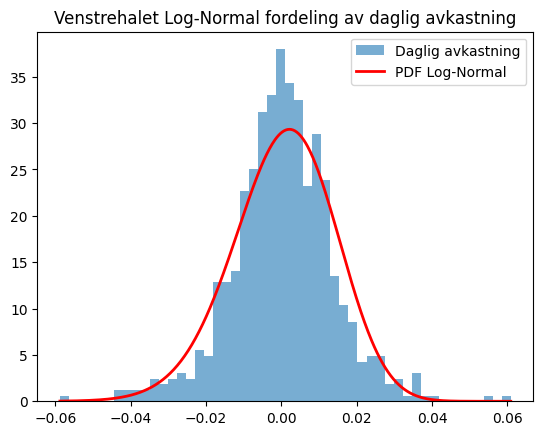

In [ ]:
r_t = np.diff(np.log(S))
sd = np.std(r_t, ddof=1)

# Shift so data can be reflected
c = r_t.max() + 0.1       # choose a shift so that c - r_t > 0
r_t_reflected = c - r_t   # now all positive

# Fit lognormal to reflected data
shape, loc, scale = stats.lognorm.fit(r_t_reflected, floc=0)
print("Reflected Lognormal parameters:", shape, loc, scale)

# Plot original histogram
plt.hist(r_t, bins=50, density=True, alpha=0.6, label="Daglig avkastning")

# Evaluate fitted PDF in original space
x = np.linspace(r_t.min(), r_t.max(), 500)
pdf_lognorm = stats.lognorm.pdf(c - x, shape, loc, scale)  # reflect back
plt.plot(x, pdf_lognorm, 'r-', lw=2, label="PDF Log-Normal")
plt.title("Venstrehalet Log-Normal fordeling av daglig avkastning")
plt.legend()
plt.show()


$
dS_t = \mu S_t dt + S_t dZ_t - \sigma S_t |dW^{u}_t| \bold{1}_{S_t >= U(t)} + \sigma S_t |dW^{l}_t| \bold{1}_{S_t <= L(t)}
$

$
dZ_t$ from lognorm samples



$
dW$ from normal samples



In [203]:
N = 1000
T = 74 # børsdager igjen i 2025
dt = 1/255
r = 0.04

In [215]:
samples = stats.lognorm.rvs(shape, loc, scale, size=(N, T))
dZ_t = c - samples

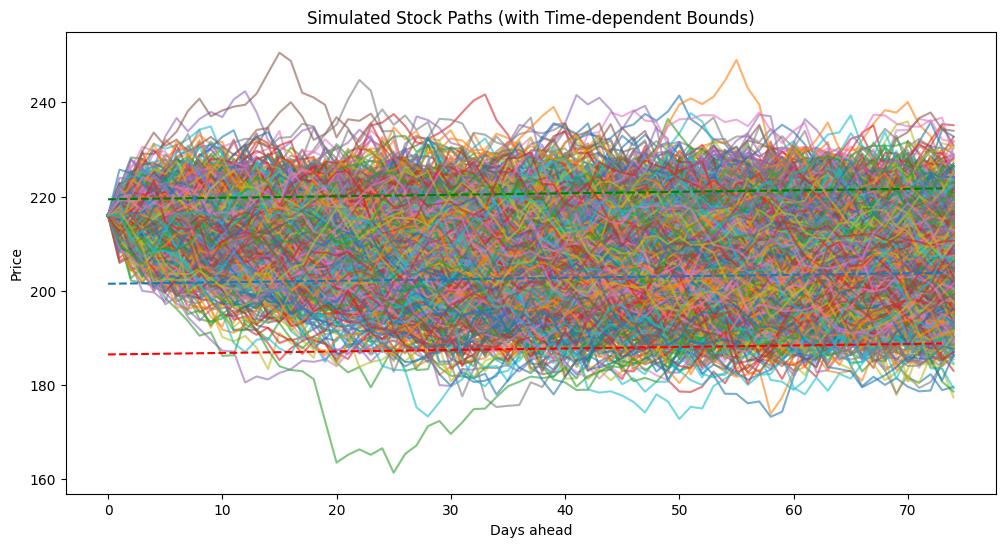

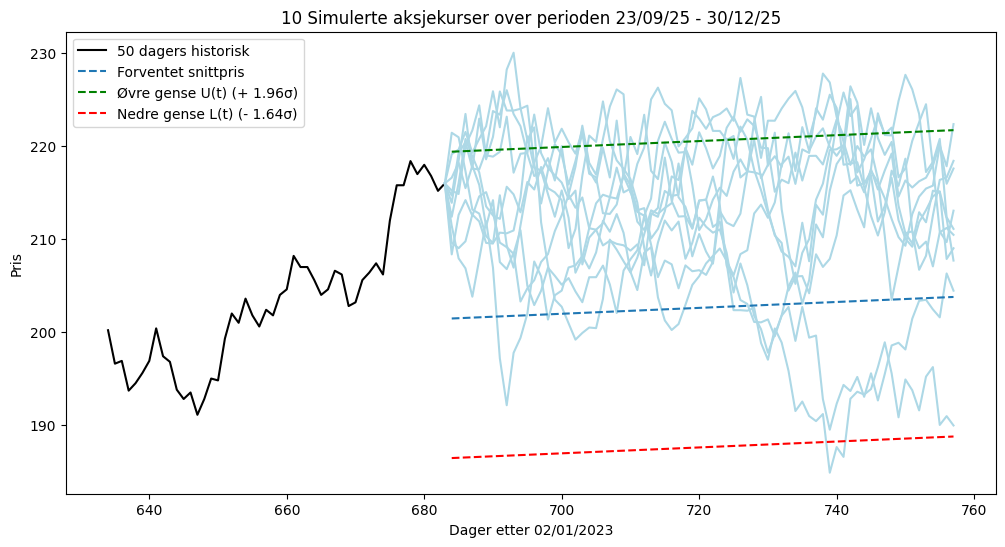

0.03060128495896528

In [236]:
# Future time steps
t_future = np.arange(len(S)+1, len(S)+T+1)
X_future = sm.add_constant(t_future)

# Predicted mean and bounds for future
S_avg_future = model.predict(X_future)
U_future = S_avg_future + 1.96*u_t
L_future = S_avg_future - 1.64*u_t

# Initialize simulation matrix
S_t = np.zeros((N, T+1))
S_t[:,0] = S[-1]

# Simulate dW_t for all paths
# dW_t = np.random.normal(size=(N, T)) * scale * np.sqrt(dt)

# Compute increments step by step with support/resistance
for t_idx in range(T):
    S_current = S_t[:, t_idx]
    
    # Base increment: drift + lognormal shock
    increment = (mu - 0.5*scale**2) * dt + dZ_t[:, t_idx]
    
    # Upper bound adjustment: reduce growth if above U_future
    above_idx = S_current >= U_future[t_idx]
    increment[above_idx] -= np.abs(dW_t[above_idx, t_idx])
    
    # Lower bound adjustment: increase growth if below L_future
    below_idx = S_current <= L_future[t_idx]
    increment[below_idx] += np.abs(dW_t[below_idx, t_idx])
    
    # Update S_t
    S_t[:, t_idx+1] = S_current * np.exp(increment)


# Plot all simulated paths
plt.figure(figsize=(12,6))
for i in range(N):
    plt.plot(np.arange(T+1), S_t[i], alpha=0.6)

plt.plot(np.arange(T), S_avg_future, label='Fitted Line', linestyle='--')
plt.plot(np.arange(T), U_future, label='Upper Bound (+ 1.96σ)', linestyle='--', color='green')
plt.plot(np.arange(T), L_future, label='Lower Bound (- 1.64σ)', linestyle='--', color='red')

plt.xlabel('Days ahead')
plt.ylabel('Price')
plt.title('Simulated Stock Paths (with Time-dependent Bounds)')
plt.show()

# Plot 10 sample paths + last 50 historical days
plt.figure(figsize=(12,6))
plt.plot(t[-50:], S[-50:], color='black', label='50 dagers historisk')
for i in range(10):
    plt.plot(np.arange(len(S), len(S)+T+1), S_t[i], color='lightblue')
plt.plot(t_future, S_avg_future, label='Forventet snittpris', linestyle='--')
plt.plot(t_future, U_future, label='Øvre gense U(t) (+ 1.96σ)', linestyle='--', color='green')
plt.plot(t_future, L_future, label='Nedre gense L(t) (- 1.64σ)', linestyle='--', color='red')
plt.xlabel('Dager etter 02/01/2023')
plt.ylabel('Pris')
plt.legend()
plt.title("10 Simulerte aksjekurser over perioden 23/09/25 - 30/12/25")
plt.show()
mu - 0.5*scale**2

Reflected Lognormal parameters: 0.5017284822686219 0 24.132417683003744


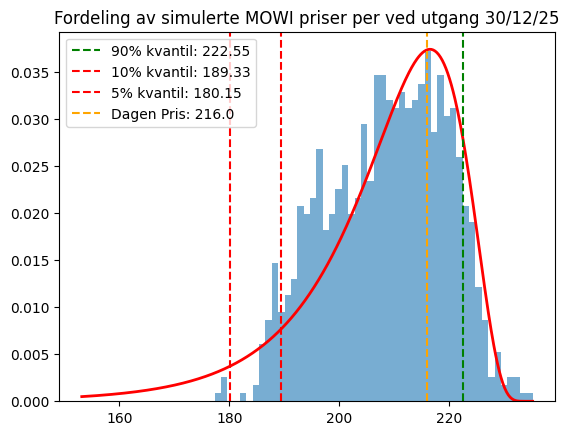

UPI: 0.15928089423272754


In [235]:
buy_price = 183.20

S_T = S_t[:,T]

c_S_T = S_T.max() + 0.1        # shift so reflected values are positive
S_T_reflected = c_S_T - S_T    # reflect

# Fit lognormal
shape_S_T, loc_S_T, scale_S_T = stats.lognorm.fit(S_T_reflected, floc=0)
print("Reflected Lognormal parameters:", shape_S_T, loc_S_T, scale_S_T)

# Plot histogram of original S_T
plt.hist(S_T, bins=50, density=True, alpha=0.6)

# Define x-axis in original space
x = np.linspace(S_T.min()-scale_S_T, S_T.max(), 500)

# Evaluate fitted PDF, reflect back
pdf_lognorm = stats.lognorm.pdf(c_S_T - x, shape_S_T, loc_S_T, scale_S_T)

q_10 = c_S_T - stats.lognorm.ppf(0.10, shape_S_T, loc_S_T, scale_S_T)
q_90 = c_S_T - stats.lognorm.ppf(0.90, shape_S_T, loc_S_T, scale_S_T)
q_95 = c_S_T - stats.lognorm.ppf(0.95, shape_S_T, loc_S_T, scale_S_T)

plt.plot(x, pdf_lognorm, 'r-', lw=2)
plt.axvline(q_10, color='green', label=f'90% kvantil: {round(q_10, 2)}', linestyle='--')
plt.axvline(q_90, color='red', label=f'10% kvantil: {round(q_90, 2)}', linestyle='--')
plt.axvline(q_95, color='red', label=f'5% kvantil: {round(q_95, 2)}', linestyle='--')
plt.axvline(S[-1], color='orange', label=f'Dagen Pris: {S[-1]}', linestyle='--')
plt.title("Fordeling av simulerte MOWI priser per ved utgang 30/12/25")
plt.legend()
plt.show()

avg = np.mean(S_T)
print(f"UPI: {(q_10 - q_90) / avg}")

Reflected Lognormal parameters: 0.23931057260481273 0 24.132417683003744


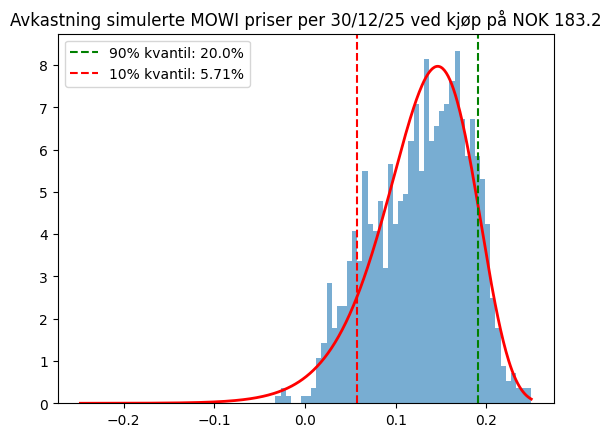

UPI: 0.0006429775656155003


In [239]:
buy_price = 183.20

R_T = np.log(S_t[:,T] / buy_price)
c_R_T = R_T.max() + 0.1        # shift so reflected values are positive
R_T_reflected = c_R_T - R_T    # reflect

# Fit lognormal
shape_R_T, loc_R_T, scale_R_T = stats.lognorm.fit(R_T_reflected, floc=0)
print("Reflected Lognormal parameters:", shape_R_T, loc_R_T, scale_S_T)

# Plot histogram of original S_T
plt.hist(R_T, bins=50, density=True, alpha=0.6)

# Define x-axis in original space
x = np.linspace(R_T.min()-scale_R_T, R_T.max(), 500)

# Evaluate fitted PDF, reflect back
pdf_lognorm = stats.lognorm.pdf(c_R_T - x, shape_R_T, loc_R_T, scale_R_T)

q_10 = c_R_T - stats.lognorm.ppf(0.10, shape_R_T, loc_R_T, scale_R_T)
q_90 = c_R_T - stats.lognorm.ppf(0.90, shape_R_T, loc_R_T, scale_R_T)

plt.plot(x, pdf_lognorm, 'r-', lw=2)
plt.axvline(q_10, color='green', label=f'90% kvantil: {round(q_10, 1)*100}%', linestyle='--')
plt.axvline(q_90, color='red', label=f'10% kvantil: {round(q_90, 4)*100}%', linestyle='--')
plt.title(f"Avkastning simulerte MOWI priser per 30/12/25 ved kjøp på NOK {buy_price}")
plt.legend()
plt.show()

avg = np.mean(S_T)
print(f"UPI: {(q_10 - q_90) / avg}")

In [198]:
import numpy as np
import pandas as pd

def evaluate_fixed_sl_tp(prices, sl_pct, tp_pct, tc_pct=0.0):
    """
    prices: array (n_steps, n_sims) with time along rows, sims along columns.
    sl_pct, tp_pct: positive fractions (e.g. 0.1 = 10% SL).
    tc_pct: round-trip transaction cost as fraction of notional.
    Returns arrays: returns (fraction), exit_index (int), outcome_str.
    """
    n_steps, n_sims = prices.shape
    returns = np.zeros(n_sims, dtype=float)
    exit_idx = np.zeros(n_sims, dtype=int)
    outcome = np.empty(n_sims, dtype=object)
    
    entry = prices[0, :]
    sl_level = entry * (1 - sl_pct)
    tp_level = entry * (1 + tp_pct)
    
    for i in range(n_sims):
        p = prices[:, i]
        # check barrier hits
        hit_sl = p <= sl_level[i]
        hit_tp = p >= tp_level[i]
        sl_first = np.argmax(hit_sl) if hit_sl.any() else None
        tp_first = np.argmax(hit_tp) if hit_tp.any() else None
        
        if not hit_sl.any() and not hit_tp.any():
            e_idx = n_steps - 1
            exit_price = p[-1]
            outcome[i] = "no_hit"
        else:
            if hit_sl.any() and hit_tp.any():
                e_idx = sl_first if sl_first < tp_first else tp_first
            elif hit_sl.any():
                e_idx = sl_first
            else:
                e_idx = tp_first
            exit_price = p[e_idx]
            outcome[i] = "sl" if (exit_price <= sl_level[i]) else "tp"
        
        gross_ret = exit_price / entry[i] - 1.0
        net_ret = gross_ret - tc_pct
        returns[i] = net_ret
        exit_idx[i] = e_idx
        
    return returns, exit_idx, outcome


def grid_search_sl_tp(prices, sl_grid, tp_grid, tc_pct=0.0, objective="mean"):
    rows = []
    for sl in sl_grid:
        for tp in tp_grid:
            rets, idxs, outs = evaluate_fixed_sl_tp(prices, sl, tp, tc_pct=tc_pct)
            mean_ret = rets.mean()
            median_ret = np.median(rets)
            std_ret = rets.std(ddof=1)
            winrate = np.mean(rets > 0)
            sharpe = mean_ret / std_ret if std_ret > 0 else np.nan
            p05 = np.percentile(rets, 5)
            p95 = np.percentile(rets, 95)
            avg_duration = idxs.mean()
            rows.append({
                "SL": sl, "TP": tp,
                "mean": mean_ret,
                "median": median_ret,
                "std": std_ret,
                "sharpe": sharpe,
                "winrate": winrate,
                "p05": p05,
                "p95": p95,
                "avg_duration_steps": avg_duration
            })
    df = pd.DataFrame(rows)
    if objective == "mean":
        best = df.loc[df["mean"].idxmax()]
    elif objective == "sharpe":
        best = df.loc[df["sharpe"].idxmax()]
    elif objective == "median":
        best = df.loc[df["median"].idxmax()]
    elif objective == "winrate":
        best = df.loc[df["winrate"].idxmax()]
    else:
        best = None
    return df, best


# --- Usage ---
# S_t is (N, T+1) = N sims x T time steps
# Transpose so it’s (T+1, N)
prices = S_t.T

sl_grid = np.linspace(0.01, 0.20, 20)   # 1% to 20% stops
tp_grid = np.linspace(0.01, 0.50, 25)   # 1% to 50% targets

df_results, best_row = grid_search_sl_tp(prices, sl_grid, tp_grid, tc_pct=0.001, objective="sharpe")
print("Best candidate:\n", best_row)
display(df_results.sort_values("mean", ascending=False).head(10))


Best candidate:
 SL                     0.190000
TP                     0.030417
mean                   0.026154
median                 0.033906
std                    0.031714
sharpe                 0.824698
winrate                0.896000
p05                   -0.056226
p95                    0.047267
avg_duration_steps    26.865000
Name: 451, dtype: float64


,SL,TP,mean,median,std,sharpe,winrate,p05,p95,avg_duration_steps
476,0.20,0.030417,0.026154,0.033906,0.031714,0.824698,0.896,-0.056226,0.047267,26.865
451,0.19,0.030417,0.026154,0.033906,0.031714,0.824698,0.896,-0.056226,0.047267,26.865
426,0.18,0.030417,0.025920,0.033906,0.032776,0.790824,0.896,-0.056274,0.047267,26.802
401,0.17,0.030417,0.025833,0.033906,0.033202,0.778060,0.896,-0.056274,0.047267,26.787
376,0.16,0.030417,0.025458,0.033906,0.034647,0.734782,0.895,-0.056587,0.047267,26.682
351,0.15,0.030417,0.024695,0.033893,0.036823,0.670648,0.893,-0.066913,0.047267,26.469
326,0.14,0.030417,0.023512,0.033851,0.040148,0.585636,0.891,-0.075084,0.047267,25.923
301,0.13,0.030417,0.022547,0.033799,0.042294,0.533096,0.889,-0.103105,0.047267,25.419
276,0.12,0.030417,0.021897,0.033774,0.042963,0.509675,0.885,-0.122144,0.047267,24.907
251,0.11,0.030417,0.020925,0.033763,0.043809,0.477634,0.878,-0.115285,0.047267,24.134


Outcome counts: {'no_hit': 1, 'sl': 1, 'tp': 124}
Winrate (rets>0): 0.9841269841269841
Mean return: 0.05451408054279865
Median return: 0.043845794614315814
5% quantile: 0.031397478412329594
95% quantile: 0.12113230387979562
Average exit step: 32.95238095238095

sl trades: count=1, mean=-0.2333, median=-0.2333

tp trades: count=124, mean=0.0573, median=0.0443

no_hit trades: count=1, mean=0.0000, median=0.0000


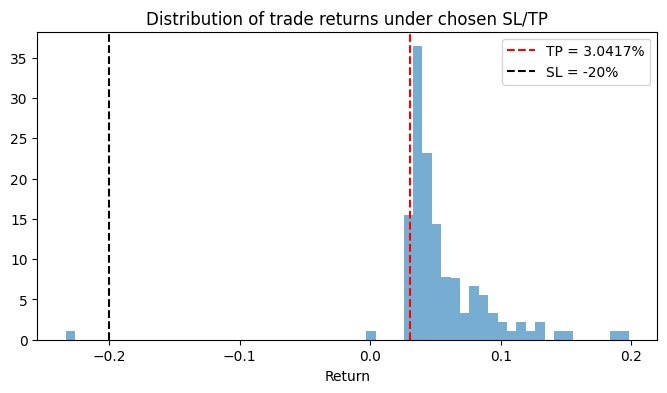

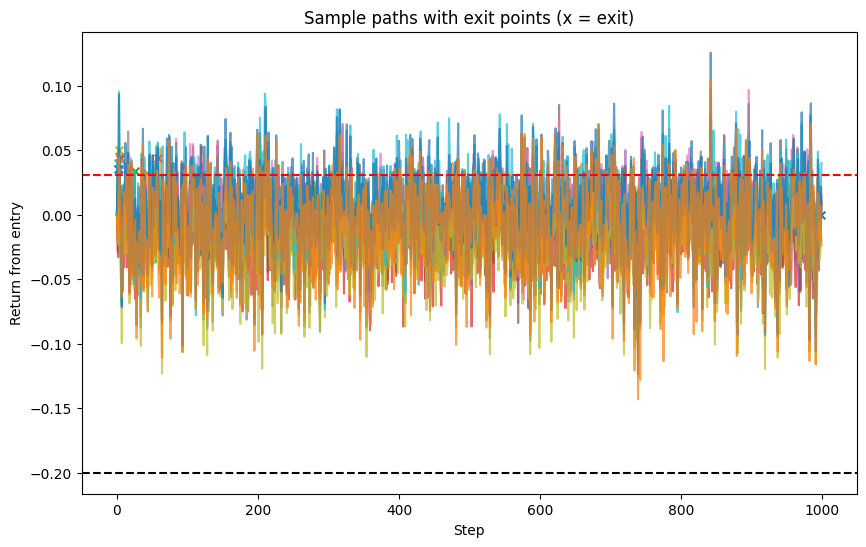

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


best_sl = 0.20
best_tp = 0.030417

rets, exit_idxs, outcomes = evaluate_fixed_sl_tp(S_t, best_sl, best_tp, tc_pct=0.0)

# counts
(unique, counts) = np.unique(outcomes, return_counts=True)
print("Outcome counts:", dict(zip(unique, counts)))
print("Winrate (rets>0):", np.mean(rets > 0))
print("Mean return:", rets.mean())
print("Median return:", np.median(rets))
print("5% quantile:", np.percentile(rets, 5))
print("95% quantile:", np.percentile(rets, 95))
print("Average exit step:", exit_idxs.mean())

# conditional stats
for label in ["sl", "tp", "no_hit"]:
    mask = outcomes == label
    if mask.any():
        print(f"\n{label} trades: count={mask.sum()}, mean={rets[mask].mean():.4f}, median={np.median(rets[mask]):.4f}")

plt.figure(figsize=(8,4))
plt.hist(rets, bins=60, density=True, alpha=0.6)
plt.axvline(best_tp, color='r', linestyle='--', label=f"TP = {best_tp:.4%}")
plt.axvline(-best_sl, color='k', linestyle='--', label=f"SL = -{best_sl:.0%}")
plt.legend()
plt.title("Distribution of trade returns under chosen SL/TP")
plt.xlabel("Return")
plt.show()

n_plot = min(12, S_t.shape[1])
plt.figure(figsize=(10,6))
for i in range(n_plot):
    p = S_t[:, i]
    plt.plot(p / p[0] - 1, alpha=0.7)              # returns from entry
    e = exit_idxs[i]
    plt.scatter([e], [p[e]/p[0]-1], s=30, marker='x')
plt.axhline(best_tp, color='r', linestyle='--')
plt.axhline(-best_sl, color='k', linestyle='--')
plt.title("Sample paths with exit points (x = exit)")
plt.xlabel("Step")
plt.ylabel("Return from entry")
plt.show()


In [243]:
np.log(S[-1] / buy_price)

0.16469995544413518